## This notebook illustrates a simple example of how Monte Carlo Simulation can be used by Airlines to book their flights.

### 1. We are making the assumption that flight cancellations do not occur due to delays or emergencies caused by the airline itself. This means that customers who miss their flight have purchased their tickets but, for some reason, were unable to catch their flight on time. In such cases, they will not be eligible for refunds for their tickets.

### 2. We need to establish a reasonable estimate for the likelihood of an individual traveler missing their flight. This estimate will be used to create a Probability Mass Function for the Binomial Distribution. While the probability of a passenger missing their flight can be influenced by various factors like punctuality, travel experience, and personal circumstances, which can vary from person to person, we will aim to determine a reasonable estimate for this value. Research suggests that, under typical and well-prepared travel conditions with no unusual delays or emergencies, the probability of an individual missing their flight might be relatively low, potentially falling within the range of 5% or even less. For the purposes of this simulation, we will assume that an individual will miss their flight 2.5% of the time, which is the mean value between 5% and 0%, with a standard deviation of 1%.

### 3. The simulation will be conducted for a single airplane with 150 seats, but it can also be adapted to model scenarios involving more than one airplane.

### 4. We will assume that the cost of a ticket is \\$350. In cases where more people show up for their flights than there are available seats, the airline will offer an additional \\$200 on top of the $350 ticket cost as a refund (totaling \\$550).

### Importing Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
import random

### We will begin by plotting the Probability Mass Function (PMF) and Cumulative Distribution Function (CDF) for the number of passengers who are expected to arrive for their flights. This will be done under the assumption that the probability of an individual successfully making it to their flight is 97.5%, which is equivalent to (1 - 0.025).

<ipython-input-2-3dc9bb0a7338>:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(k, People_show_up.pmf(k), 'b', label = 'Binomial')


Text(0.5, 1.0, 'Cumulative Distribution Function # of people who show up')

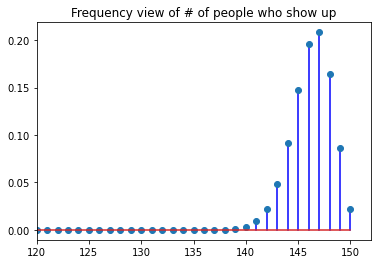

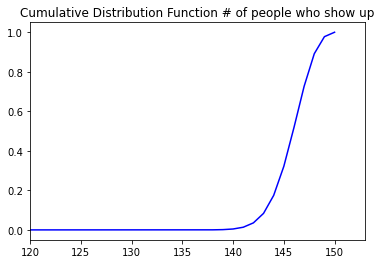

In [2]:
Seats = 150 # on average, planes have 150 seats available
Prob_show = 0.975 # probability that a person will show up for his/her flight

People_show_up = st.binom(Seats, Prob_show)

k = range(Seats+1) # Used for graphing purposes
plt.figure()
plt.stem(k, People_show_up.pmf(k), 'b', label = 'Binomial')
plt.xlim(120,152)
plt.title('Frequency view of # of people who show up')

plt.figure()
plt.plot(k, People_show_up.cdf(k), 'b', label = 'Binomial')
plt.xlim(120,153)
plt.title('Cumulative Distribution Function # of people who show up')


### Upon examination of the Probability Mass Function (PMF), we observe that the likelihood of precisely 147 passengers showing up for their flights is slightly above 20%. Conversely, the probability of precisely 150 passengers showing up is approximately 2.5%. Meanwhile, the Cumulative Distribution Function (CDF) reveals that the probability of fewer than 145 passengers showing up for their flights is less than 30%.

### We will utilize this information to perform simulations of the number of passengers who arrive for their flights, based on the quantity of tickets sold by the airline. The number of tickets the airline will sell will range from 150 to 160 in even increments. Once the number of tickets to be sold is determined, we will carry out 50,000 trials for each ticket quantity. In each trial, we will record both the actual number of passengers who showed up for their flights and the profit earned by the airline, while adhering to the previously outlined assumptions.

### Simulation

In [6]:
Seats = 150
Ticket_Price = 350
Bump_Cost = 550 # We give customers extra $200 if they get bumped out of the plane
Tickets_sold = range(150,161,2) # Number of tickets that we decided to sell at each iteration

def overbook(tprice, bumpcost, pshowup, tickets_sold):
    bumped_people = max(pshowup - Seats, 0)
    revenue = tprice*tickets_sold
    cost = bumped_people*bumpcost
    
    return revenue - cost

def simulation(N_simulations, tprice, bump_cost, tickets_sold):
    people_show_up_vec = []
    profit_vec = []
    
    for i in range(N_simulations):
        prob_show = min(st.norm(0.975,0.01).rvs(), 1.0) # Assume normal distribution with mean 97.5% and stdev of 1%
        people_show = st.binom(tickets_sold, prob_show).rvs()
        profit = overbook(tprice, bump_cost, people_show, tickets_sold)
        people_show_up_vec.append(people_show)
        profit_vec.append(profit)
        
    return people_show_up_vec, profit_vec

N = 50000 # Number of simulations: 50K
People_show_up_mat = [] # Matrix storing simulated number of people showing up
Profit_mat = [] # Matrix storing simulated profits

for tickets in Tickets_sold:
    people_showed_up, profit = simulation(N, Ticket_Price, Bump_Cost, tickets)
    People_show_up_mat.append(people_showed_up)
    Profit_mat.append(profit)
    
Profit_mean = np.mean(Profit_mat, axis=1) # Axis=1 calculates for each row
Profit_std = np.std(Profit_mat, axis=1)
Profit_mse = Profit_std/np.sqrt(N)
print("Simulation complete!")

Simulation complete!


### Plotting Expected Profits and CDF function of selling more tickets than maximum allocated seats (150).

Mean profits: [52500.    53067.219 53320.036 53262.664 53008.073 52683.775] 

Mean std error of profits: [0.         1.37076151 3.18213092 4.69298631 5.60501771 5.99399566] 



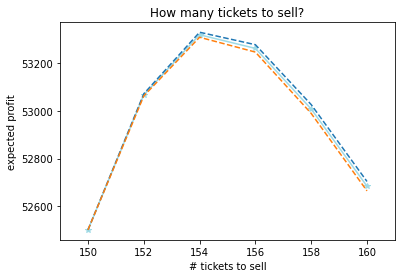

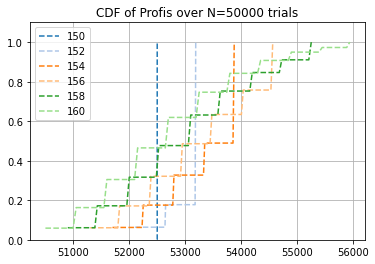

In [7]:
cmap = plt.get_cmap("tab20")  # Colormap to choose a color
print('Mean profits:', Profit_mean,'\n') # print mean profits for different # of tickets_to_sell
print('Mean std error of profits:', Profit_mse,'\n')

plt.figure()
plt.plot(Tickets_sold, Profit_mean, '*-', color=cmap(2.25))
plt.title('How many tickets to sell?')
plt.xlabel('# tickets to sell')
plt.ylabel('expected profit')
plt.xlim(min(Tickets_sold)-1,max(Tickets_sold)+1)
plt.plot(Tickets_sold, Profit_mean+3.3*Profit_mse, '--') # 99.99% confidence interval
plt.plot(Tickets_sold, Profit_mean-3.3*Profit_mse, '--')
plt.show()


plt.figure()
colors = [cmap(i) for i in range(len(Tickets_sold))]
for i in range(len(colors)):
    counts, bin_edges = np.histogram(Profit_mat[i], bins=100, density=False)
    counts = counts.astype(float)/N
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf, linestyle='--', color=colors[i], label=str(Tickets_sold[i]))
    plt.ylim((0,1.1))
    plt.grid(True)
plt.title('CDF of Profis over N=%i trials' %N)
plt.legend()
plt.show()


### Based on the analysis of expected profits and the cumulative distribution function of profits, it is advisable for the airline to sell 152 tickets. This represents an increase of 2 seats compared to the current situation. This decision is supported by the fact that both the expected profit and the concept of stochastic dominance favor selling 152 seats over the initial 150.

### Selling 154 seats does offer the potential for higher expected profits, but it comes with increased risk. This is because it relies on the assumption that at least 4 people won't show up for their flights. However, opting to sell more tickets not only increases the likelihood of overbooking and having to deny boarding to passengers, but it also carries the risk of damaging the airline's reputation. If airline decides to sell 154 tickets and earn extra profits while exposing it to more risk, they can do so.